In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from statsmodels.tsa.stattools import kpss
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading demand dataset

In [ ]:
DEMAND_DIR = 'drive/MyDrive/demand_with_weather_1h.parquet'
CLEAN_DATA_DIR = 'drive/MyDrive/CleanDatasetPackage/clean_data.parquet'

In [ ]:
df_10m = pd.read_parquet(DEMAND_DIR)
df_10m = df_10m.sort_index()
df_10m

,PULocationID,demand,Borough,temp,icon
timestamp,,,,,
2023-01-01 00:00:00,4,24.0,Manhattan,12.2,rain
2023-01-01 00:00:00,165,1.0,Brooklyn,12.2,rain
2023-01-01 00:00:00,167,1.0,Bronx,11.9,rain
2023-01-01 00:00:00,169,1.0,Bronx,11.9,rain
2023-01-01 00:00:00,171,1.0,Queens,11.1,rain
...,...,...,...,...,...
2023-04-30 23:00:00,8,1.0,Queens,15.9,rain
2023-04-30 23:00:00,9,1.0,Queens,15.9,rain
2023-04-30 23:00:00,11,1.0,Brooklyn,16.0,rain


### plot PACF of 10 pulocationid based on time( to identify num of lags and window size )

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


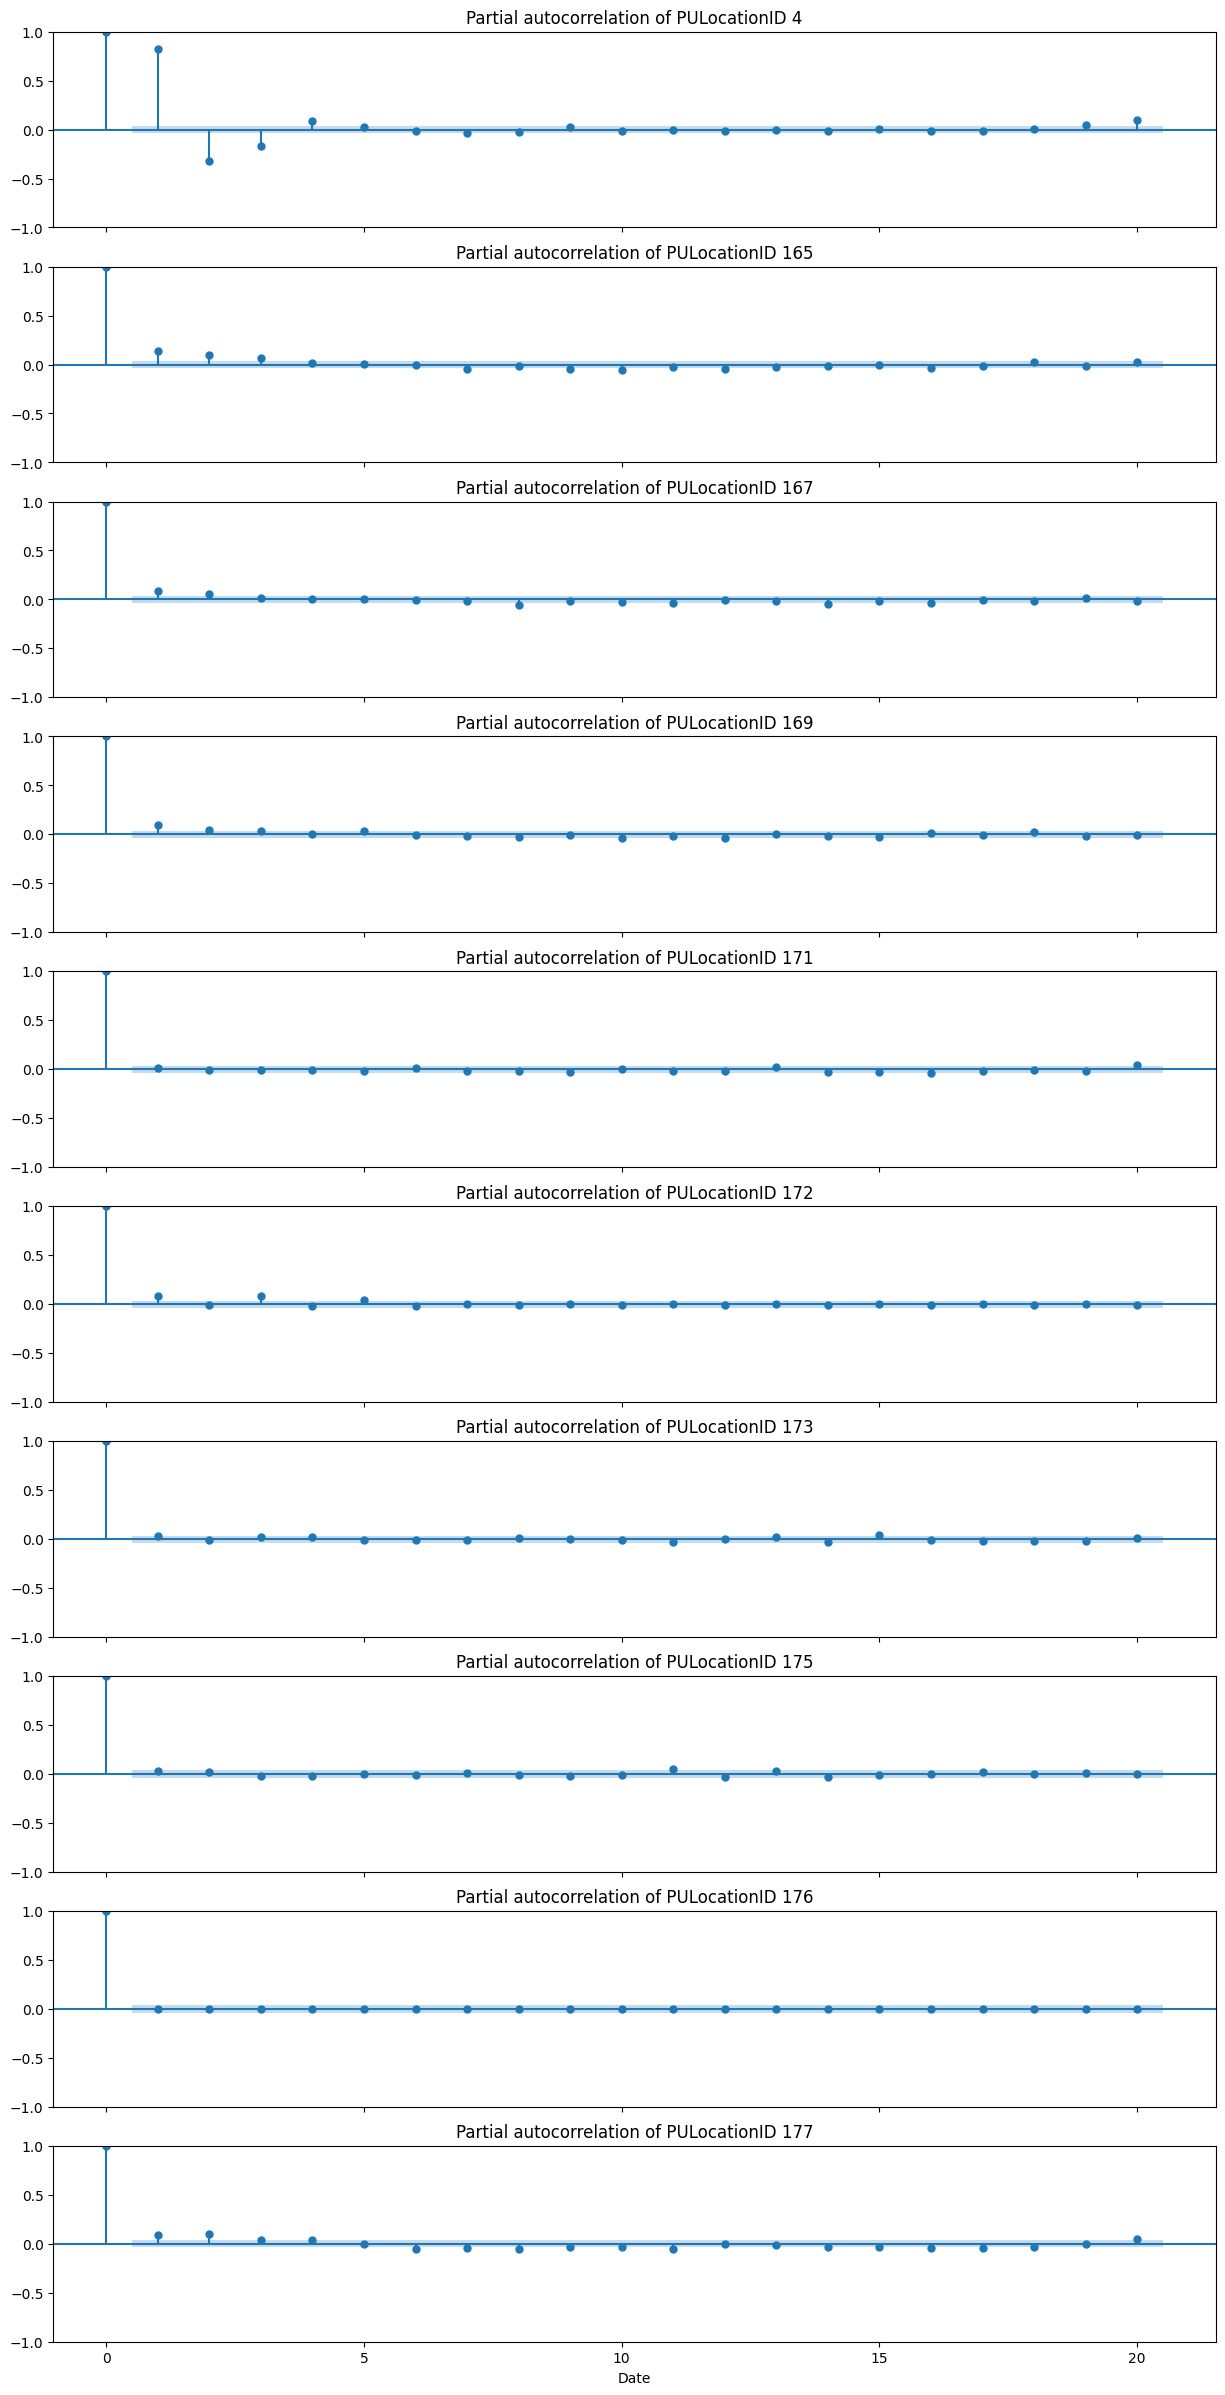

In [ ]:

pulocationid_list = df_10m['PULocationID'].unique()[:10]

fig, axs = plt.subplots(len(pulocationid_list), 1, figsize=(15, 30), sharex=True)

for i, pulocationid in enumerate(pulocationid_list):
    pulocationid_data = df_10m[df_10m['PULocationID'] == pulocationid]
    plot_pacf(pulocationid_data["demand"], lags=20, ax=axs[i])
    axs[i].set_title(f"Partial autocorrelation of PULocationID {pulocationid}")

axs[-1].set_xlabel('Date')

plt.show()

### plot demand of 10 pulocationid based on time

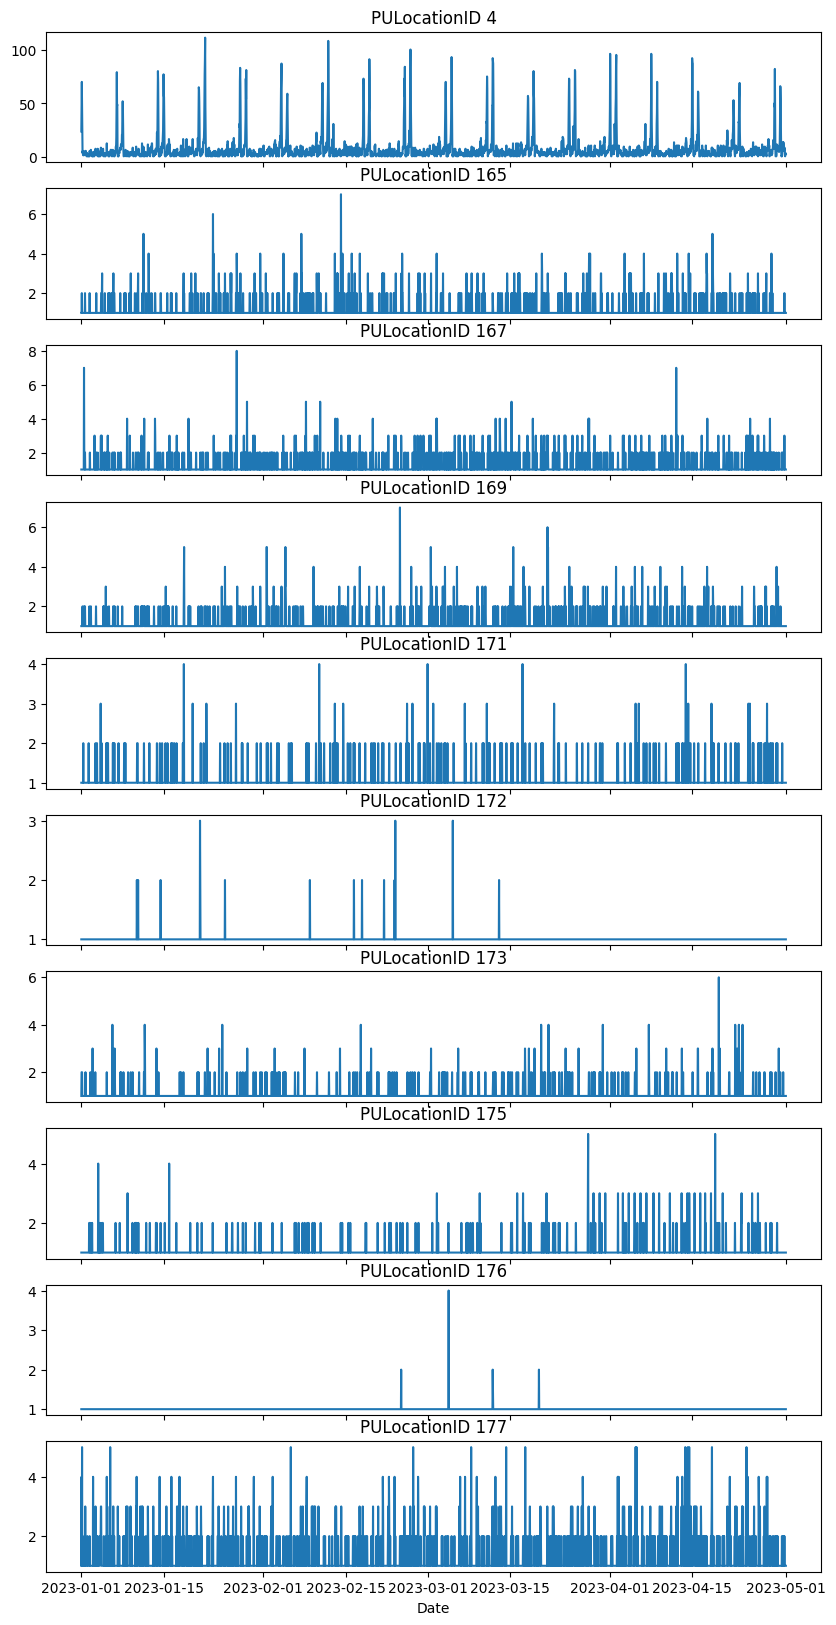

In [ ]:
pulocationid_list = df_10m['PULocationID'].unique()[:10]

fig, axs = plt.subplots(len(pulocationid_list), 1, figsize=(10, 20), sharex=True)

for i, pulocationid in enumerate(pulocationid_list):
    pulocationid_data = df_10m[df_10m['PULocationID'] == pulocationid]
    axs[i].plot(pulocationid_data.index, pulocationid_data['demand'])
    axs[i].set_title(f'PULocationID {pulocationid}')

axs[-1].set_xlabel('Date')

plt.show()

### Label encoding of borough and icon

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Fit the label encoder to the categorical column
df_10m['Borough'] = le.fit_transform(df_10m['Borough'])
df_10m['icon'] = le.fit_transform(df_10m['icon'])


In [ ]:
df_10m

,PULocationID,demand,Borough,temp,icon
timestamp,,,,,
2023-01-01 00:00:00,4,24.0,3,12.2,6
2023-01-01 00:00:00,165,1.0,1,12.2,6
2023-01-01 00:00:00,167,1.0,0,11.9,6
2023-01-01 00:00:00,169,1.0,0,11.9,6
2023-01-01 00:00:00,171,1.0,4,11.1,6
...,...,...,...,...,...
2023-04-30 23:00:00,8,1.0,4,15.9,6
2023-04-30 23:00:00,9,1.0,4,15.9,6
2023-04-30 23:00:00,11,1.0,1,16.0,6


### Feature Extraction for timestamp

In [ ]:
df_10m.reset_index(inplace=True)
df_10m["seconds"] = df_10m["timestamp"].map(pd.Timestamp.timestamp)

In [ ]:
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

seconds_in_day = 24 * 60 * 60
seconds_in_week = 7 * seconds_in_day

df_10m["time_sin"] = sin_transformer(seconds_in_day).fit_transform(df_10m["seconds"])
df_10m["time_cos"] = cos_transformer(seconds_in_day).fit_transform(df_10m["seconds"])

df_10m["week_sin"] = sin_transformer(seconds_in_week).fit_transform(df_10m["seconds"])
df_10m["week_cos"] = cos_transformer(seconds_in_week).fit_transform(df_10m["seconds"])

df_10m.drop('seconds' , axis=1, inplace=True)
df_10m.set_index("timestamp", inplace=True)
df_10m

,PULocationID,demand,Borough,temp,icon,time_sin,time_cos,week_sin,week_cos
timestamp,,,,,,,,,
2023-01-01 00:00:00,4,24.0,3,12.2,6,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,165,1.0,1,12.2,6,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,167,1.0,0,11.9,6,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,169,1.0,0,11.9,6,-1.129255e-11,1.000000,0.433884,-0.900969
2023-01-01 00:00:00,171,1.0,4,11.1,6,-1.129255e-11,1.000000,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...
2023-04-30 23:00:00,8,1.0,4,15.9,6,-2.588190e-01,0.965926,-0.399892,-0.916562
2023-04-30 23:00:00,9,1.0,4,15.9,6,-2.588190e-01,0.965926,-0.399892,-0.916562
2023-04-30 23:00:00,11,1.0,1,16.0,6,-2.588190e-01,0.965926,-0.399892,-0.916562


### Add weekday?

In [ ]:
df_10m["week_day"] = df_10m.index.dayofweek

### Add holiday

In [ ]:
df_10m = df_10m.reset_index()

In [ ]:
holidays = pd.to_datetime(["2023-1-2","2023-1-16", "2023-2-20", "2023-5-29","2023-7-4", "2023-9-4", "2023-10-9", "2023-11-10", "2023-11-23","2023-12-25"])

def is_holiday(date):
    return (date in holidays)

df_10m['holiday'] = np.where((df_10m["timestamp"].dt.dayofweek >= 5) | (df_10m["timestamp"].dt.date.apply(is_holiday)), 1, 0)
df_10m = df_10m.set_index("timestamp")

### Adding window feature for demand

In [ ]:
def add_window_feature(df, col, window):
  grouped_df = df.groupby('PULocationID')

  # calculate the rolling mean and standard deviation using a window of 8 for each group
  rolling_mean = grouped_df[col].rolling(window=window, closed="left").mean().reset_index() # closed="left" excludes current demand
  rolling_std = grouped_df[col].rolling(window=window, closed="left").std().reset_index()

  # rename the columns of the resulting dataframes
  rolling_mean.columns = ['PULocationID', 'timestamp', 'rollingMean']
  rolling_std.columns = ['PULocationID', 'timestamp', 'rollingStd']
  rolling_mean["timestamp"] = pd.to_datetime(rolling_mean["timestamp"])
  rolling_std["timestamp"] = pd.to_datetime(rolling_std["timestamp"])

  df = df.reset_index()

  df = pd.merge(df, rolling_mean, on=['timestamp', 'PULocationID'], how='left')
  df = pd.merge(df, rolling_std, on=['timestamp', 'PULocationID'], how='left')
  return df

def rolling_fillna(df, col):
  grouped = df.groupby("PULocationID")
  df[col] = grouped[col].bfill()
  return df


df_10m = add_window_feature(df_10m, "demand", 3)  # count of window shall be tuned
df_10m = rolling_fillna(df_10m, "rollingMean")
df_10m = rolling_fillna(df_10m, "rollingStd")
df_10m = df_10m.set_index("timestamp")

In [ ]:
df_10m

,PULocationID,demand,Borough,temp,icon,time_sin,time_cos,week_sin,week_cos,week_day,holiday,rollingMean,rollingStd
timestamp,,,,,,,,,,,,,
2023-01-01 00:00:00,4,24.0,3,12.2,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,1,45.666667,23.115651
2023-01-01 00:00:00,165,1.0,1,12.2,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,1,1.333333,0.577350
2023-01-01 00:00:00,167,1.0,0,11.9,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,1,1.000000,0.000000
2023-01-01 00:00:00,169,1.0,0,11.9,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,1,1.000000,0.000000
2023-01-01 00:00:00,171,1.0,4,11.1,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,1,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:00:00,8,1.0,4,15.9,6,-2.588190e-01,0.965926,-0.399892,-0.916562,6,1,1.000000,0.000000
2023-04-30 23:00:00,9,1.0,4,15.9,6,-2.588190e-01,0.965926,-0.399892,-0.916562,6,1,1.000000,0.000000
2023-04-30 23:00:00,11,1.0,1,16.0,6,-2.588190e-01,0.965926,-0.399892,-0.916562,6,1,1.000000,0.000000


### Add lag for demand

In [ ]:
# 1h lagging
number_of_lags = 6  # lags shall be tuned
grouped = df_10m.groupby("PULocationID")
for i in range(1, number_of_lags + 1):
  df_10m['demand_lagged'+str(i)] = grouped["demand"].shift(i)

# fill nan lags
grouped = df_10m.groupby("PULocationID")
for i in range(1, number_of_lags + 1):
  df_10m['demand_lagged'+str(i)] = grouped['demand_lagged'+str(i)].bfill()

# one week lag
grouped = df_10m.groupby("PULocationID")
df_10m['demand_lagged_weekly'] = grouped["demand"].shift(7*24)
df_10m["demand_lagged_weekly"] = grouped["demand_lagged_weekly"].bfill()

### Splitting data

In [ ]:
split_date = '2023-4-1 00:00:00'
data_train = df_10m.loc[df_10m.index < split_date].copy()
data_test = df_10m.loc[df_10m.index >= split_date].copy()
print(data_train.shape, data_test.shape)

(567817, 20) (189360, 20)


### target encoding for PULocationID

In [ ]:
mean_demand_per_location = data_train.groupby('PULocationID')['demand'].mean()
data_train['PULocationID-encoded'] = data_train['PULocationID'].map(mean_demand_per_location)
data_test['PULocationID-encoded'] = data_test['PULocationID'].map(mean_demand_per_location)

### Save demand dataset with features in drive

In [ ]:
demand_dataset_with_features = pd.concat([data_train, data_test], axis=0)
demand_dataset_with_features.to_parquet("final_demand_with_features_1h.parquet")

In [ ]:
demand_dataset_with_features

,PULocationID,demand,Borough,temp,icon,time_sin,time_cos,week_sin,week_cos,week_day,...,rollingMean,rollingStd,demand_lagged1,demand_lagged2,demand_lagged3,demand_lagged4,demand_lagged5,demand_lagged6,demand_lagged_weekly,PULocationID-encoded
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,4,24.0,3,12.2,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,...,45.666667,23.115651,24.0,24.0,24.0,24.0,24.0,24.0,24.0,7.780917
2023-01-01 00:00:00,165,1.0,1,12.2,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,...,1.333333,0.577350,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.189440
2023-01-01 00:00:00,167,1.0,0,11.9,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,...,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.241315
2023-01-01 00:00:00,169,1.0,0,11.9,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,...,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.177860
2023-01-01 00:00:00,171,1.0,4,11.1,6,-1.129255e-11,1.000000,0.433884,-0.900969,6,...,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.077351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:00:00,8,1.0,4,15.9,6,-2.588190e-01,0.965926,-0.399892,-0.916562,6,...,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.019453
2023-04-30 23:00:00,9,1.0,4,15.9,6,-2.588190e-01,0.965926,-0.399892,-0.916562,6,...,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.064382
2023-04-30 23:00:00,11,1.0,1,16.0,6,-2.588190e-01,0.965926,-0.399892,-0.916562,6,...,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.078277


### Train xgboost model

In [ ]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50) #n_estimator and early stopping shall be tuned
X_train = data_train.drop(["demand"], axis=1)
y_train = data_train["demand"]

X_test = data_test.drop(["demand"], axis=1)
y_test = data_test["demand"]

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

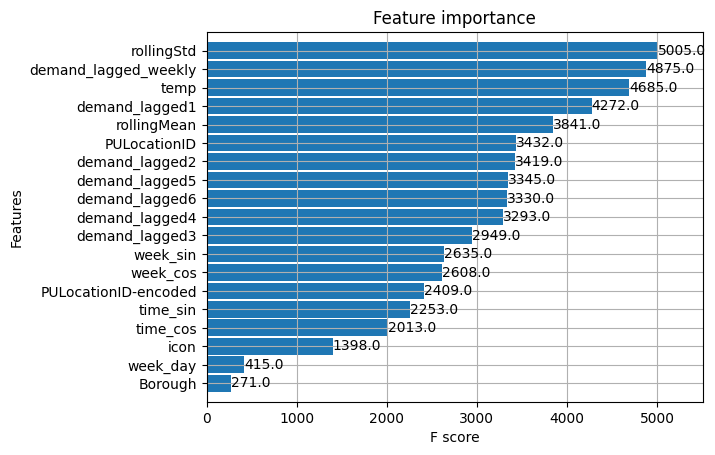

In [ ]:
plot_importance(reg, height=0.9)

In [ ]:
def evaluate():
  print("r2-score: ",r2_score(y_test, data_test["demand_prediction"]))
  print("RMSE: ", np.sqrt(mean_squared_error(y_test, data_test["demand_prediction"])))
  print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, data_test["demand_prediction"])))
  print("MAE: ",mean_absolute_error(y_test, data_test["demand_prediction"]))
  print("MAPE: ",mean_absolute_percentage_error(y_test, data_test["demand_prediction"]))


<Axes: xlabel='timestamp'>

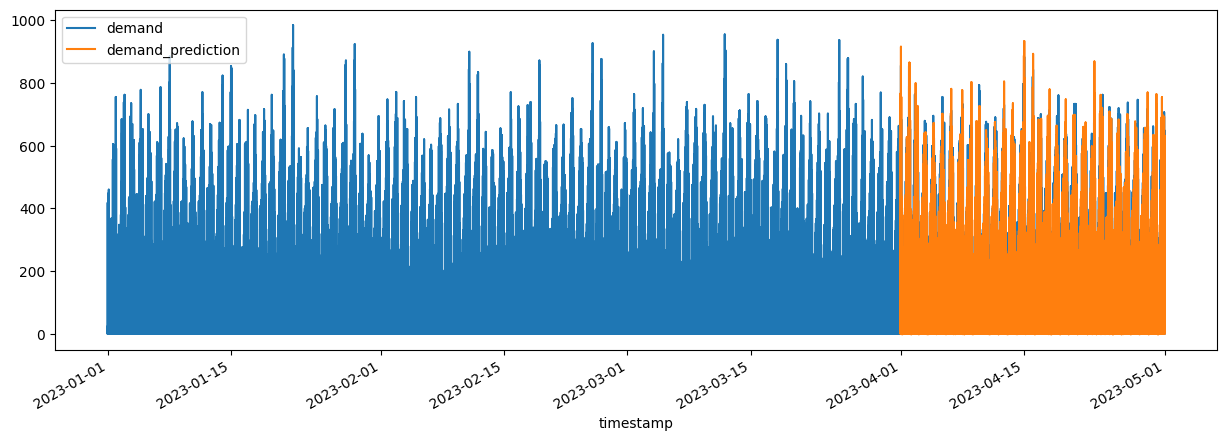

In [ ]:
data_test['demand_prediction'] = reg.predict(X_test)
# put zero instead of negative demand prediction
data_test['demand_prediction'] = np.where(data_test['demand_prediction'] < 0, 0, data_test['demand_prediction'])

data_all = pd.concat([data_test, data_train], sort=False)
data_all[['demand','demand_prediction']].plot(figsize=(15, 5))

In [ ]:
evaluate()

r2-score:  0.9691385249788093
RMSE:  12.306627206779922
RMSLE:  0.272202007344406
MAE:  3.75113628860792
MAPE:  0.28383029663772663


### plot predicted part of dataset

<Axes: xlabel='timestamp'>

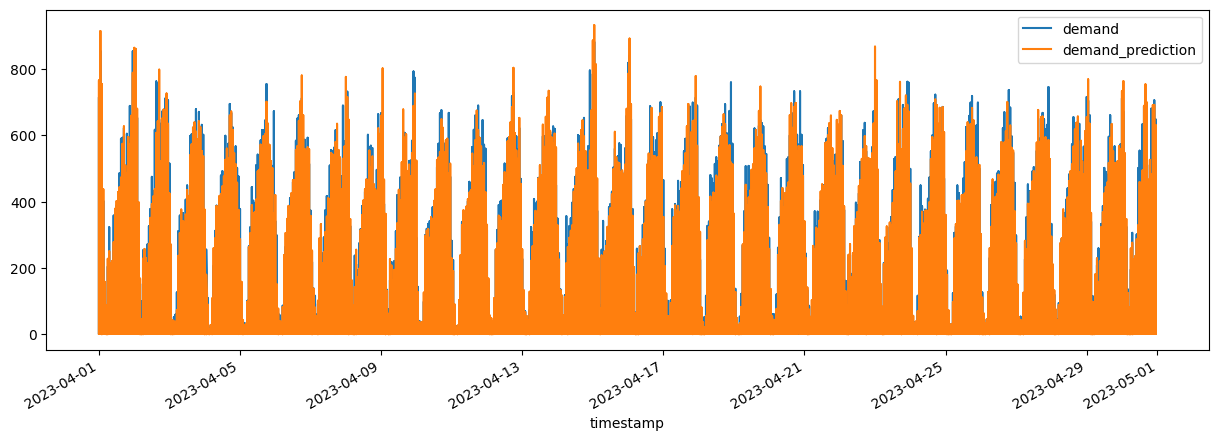

In [ ]:
one_month_data = data_all.loc[data_all.index >= "2023-4-1 00:00:00"]
one_month_data[['demand','demand_prediction']].plot(figsize=(15, 5))